# HMDA Data Analysis

> The Home Mortgage Disclosure Act (HMDA) requires mortgage lenders in the United States to disclose information about the mortgage lending decisions they have made. Specifically, it requires that each lender report on all of the official mortgage applications they have received and whether or not the application was accepted or denied. This dataset provides a rich problem for data analysis and data science and is publicly available through their API. We would like you to build a classifier that predicts from the disclosed attributes of the mortgage applications whether or not the application will be approved. We are less concerned about the final accuracy of the classifier and more about the process and framework you use to get there. Please prepare a brief presentation in which you walk us through your process, results, and discoveries along the way. We hope to see the code used to explore and analyze the data. 

> The HMDA dataset is large, feel free to select a specific cut of the data for model development, for example a specific geography or a specific type of mortgage. The dataset can be downloaded here: https://www.consumerfinance.gov/data-research/hmda/

In [1]:
import pandas as pd
import seaborn as sns
import os

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Preprocessing

The HMDA website says they have something on the order of 10-20 million records each year. Assuming a mean of < 2 mortgage applications per accepted mortgage, that's a surprisingly high turnover for mortgages in this country. This is clearly going to be a multi-gigabyte dataset. I'd like to get a full business cycle in there, so we'll limit records to owner occupancy single-family homes in NY State, but get the full dataset since 2007.

In [3]:
# We're going to have to download the file ahead of time. It's about 1.5GB so we don't want to have to fetch it from a cold start every time we run this notebook.
if not 'rawdata.pqt' in os.listdir():
    url = "https://api.consumerfinance.gov:443/data/hmda/slice/hmda_lar.csv?$where=state_code%3D36+AND+property_type+IN+(1%2C2)+AND+owner_occupancy%3D1+AND+lien_status%3D1&$limit=0&$offset=0"
    rawdata = pd.read_csv(url)
    rawdata.to_parquet("rawdata.pqt")
else:
    rawdata = pd.read_parquet("rawdata.pqt")
rawdata.shape

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15,16,17,32,33,34,38,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4281178, 78)

77 features is far too many to graph. Let's get an idea of how many are actually used.

In [4]:
completeness = rawdata.notnull().sum(axis=0)
len(completeness.where(completeness>rawdata.shape[0]/2).dropna())

53

Ok, a bit more than half have data more than 50% of the time. Since our motivation is to predict the approval likelihood of new mortgages, we'll drop the rest as not worth modeling.

In [5]:
rawdata = rawdata.loc[:,completeness.where(completeness>rawdata.shape[0]/2).dropna().index]

That's still too much to look at, though. What about redundancies?

In [6]:
rawdata.iloc[0,:]

action_taken                                                                      3
action_taken_name                       Application denied by financial institution
agency_code                                                                       7
agency_abbr                                                                     HUD
agency_name                             Department of Housing and Urban Development
applicant_ethnicity                                                               2
applicant_ethnicity_name                                     Not Hispanic or Latino
applicant_income_000s                                                            31
applicant_race_1                                                                  5
applicant_race_name_1                                                         White
applicant_sex                                                                     2
applicant_sex_name                                                          

Quite a few. Build out concordances for the dual index-string fields.

In [7]:
concordances = {v:dict(rawdata[[v, v+'_name']].head(10000).drop_duplicates().values) for
                v in [v for v in rawdata.columns if v+'_name' in rawdata.columns]}

concordances

{'action_taken': {3: 'Application denied by financial institution',
  1: 'Loan originated',
  5: 'File closed for incompleteness',
  2: 'Application approved but not accepted',
  4: 'Application withdrawn by applicant',
  7: 'Preapproval request denied by financial institution',
  8: 'Preapproval request approved but not accepted'},
 'applicant_ethnicity': {2: 'Not Hispanic or Latino',
  3: 'Information not provided by applicant in mail, Internet, or telephone application',
  1: 'Hispanic or Latino',
  4: 'Not applicable'},
 'applicant_sex': {2: 'Female',
  1: 'Male',
  3: 'Information not provided by applicant in mail, Internet, or telephone application',
  4: 'Not applicable'},
 'co_applicant_ethnicity': {5: 'No co-applicant',
  2: 'Not Hispanic or Latino',
  3: 'Information not provided by applicant in mail, Internet, or telephone application',
  1: 'Hispanic or Latino',
  4: 'Not applicable'},
 'co_applicant_sex': {5: 'No co-applicant',
  2: 'Female',
  1: 'Male',
  3: 'Information

Now we can drop the names

In [8]:
rawdata.drop([k+'_name' for k in concordances], axis=1, inplace=True)
rawdata.shape

(4281178, 39)

In [93]:
non_conform = ['applicant_race', 'co_applicant_race']
for v in non_conform:
    concordances[v+'_1'] = dict(rawdata[[v+'_1', v+'_name_1']].head(10000).drop_duplicates().values)
    rawdata.drop(v+'_name_1', axis=1, inplace=True)
rawdata.shape

(3584858, 31)

More removals:

* We can drop state info, too, since it's all NY. 
* I'm going to leave in agency abbreviation and remove the code and name. They didn't fit the pattern for the concordance.
* sequence_number is a unique id for each respondent_id (which is the reporting institution id, and may be relevant)

In [9]:
rawdata.drop(['state_code', 'state_abbr', 'state_name', 'agency_name', 'agency_code', 'sequence_number'], axis=1, inplace=True)
rawdata.shape

(4281178, 33)

Finally, we need to simplify the decision codes. We only care about loans that were approved or denied. We can filter out incomplete files, which will presumably be difficult to model anyway, 'Preapprovals' mean a decision was made on the customer's creditworthiness without a specific property attached. At a minimum, these should be modeled separately. For the purposes of this exercise, I'll get rid of those, too. Withdrawn applications should go, too. The remaining actions are 1,2,3, where 3 is a denial and 1 and 2 are approvals.

In [10]:
rawdata = rawdata.loc[rawdata.action_taken <= 3,:]
rawdata.shape

(3584858, 33)

In [11]:
rawdata = rawdata.assign(approved=rawdata.action_taken < 3)
rawdata.drop("action_taken", axis=1, inplace=True)

In [94]:
rawdata.to_parquet("processed_data.pqt")

## Exploratory Data Analysis

I'm going to start off modeling with an SVM to get a baseline before moving on to more directed regressions, so I'll need to look at distributions to see how to categorize continuous values. 

We'll also want to see what our basic prior is on approvals.

In [14]:
smpl = rawdata.sample(n=10000) #spare our processor if we wind up graphing points

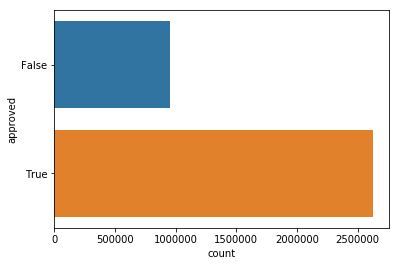

In [17]:
sns.countplot(y="approved", data=rawdata)

There actually aren't that many continuous/high category values.

In [18]:
smpl.columns

Index(['agency_abbr', 'applicant_ethnicity', 'applicant_income_000s',
       'applicant_race_1', 'applicant_race_name_1', 'applicant_sex',
       'application_date_indicator', 'as_of_year', 'census_tract_number',
       'co_applicant_ethnicity', 'co_applicant_race_1',
       'co_applicant_race_name_1', 'co_applicant_sex', 'county_code',
       'county_name', 'hoepa_status', 'lien_status', 'loan_purpose',
       'loan_type', 'msamd', 'owner_occupancy', 'preapproval', 'property_type',
       'purchaser_type', 'respondent_id', 'hud_median_family_income',
       'loan_amount_000s', 'number_of_1_to_4_family_units',
       'number_of_owner_occupied_units', 'minority_population', 'population',
       'tract_to_msamd_income', 'approved'],
      dtype='object')

In [58]:
lots_of_values = ['population', 'minority_population', 'applicant_income_000s', 'hud_median_family_income', 
                  'census_tract_number', 'tract_to_msamd_income']
len(lots_of_values)

6

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


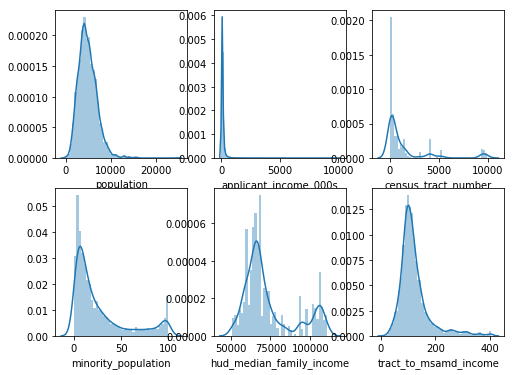

In [61]:
f, axes = plt.subplots(2,3, figsize=(8.05,6))
for i, v in enumerate(lots_of_values):
    sns.distplot(smpl[v].dropna(), ax=axes[i % 2, i // 2])

Someone with an income of 10,000,000 applied for a mortgage? I'm kind of curious how much it was for.

In [50]:
smpl.loc[smpl.applicant_income_000s>5000, ['applicant_income_000s', 'loan_amount_000s']]

,applicant_income_000s,loan_amount_000s
2214445,7545.0,77
2000875,9999.0,1463
1670314,5200.0,3000
3607446,7800.0,710
1846806,9021.0,6750


I'm guessing the first one is a data entry error. Who would go to the trouble? Even the tax advantage isn't worth it.

We can probably set our cutpoints just based on quantiles for these. `census_tract_number` should probably just be dropped for the SVM.

What's the relationship between race and income among mortgage applicants?

/home/cnaylor/env/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


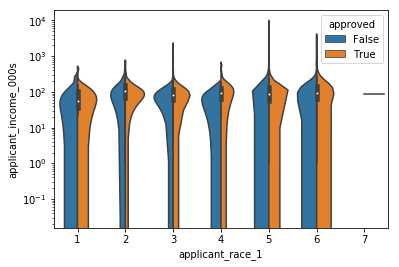

In [101]:
fig, ax = plt.subplots()
ax.set(yscale="log")
g = sns.catplot(x='applicant_race_1', y='applicant_income_000s', hue='approved', kind='violin', 
            split=True, data=smpl, ax=ax)

In [99]:
concordances['applicant_race_1']

{5: 'White',
 6: 'Information not provided by applicant in mail, Internet, or telephone application',
 3: 'Black or African American',
 1: 'American Indian or Alaska Native',
 2: 'Asian',
 4: 'Native Hawaiian or Other Pacific Islander'}

The obvious patterns are the disproportionate approval for Asians, and disapproval for African Americans and Pacific Islanders.

Anyway, on to modeling, which we'll do on a new notebook.

In [102]:
import pickle

In [104]:
with open('concordance.pkl', 'wb') as f:
    pickle.dump(concordances, f)